In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# Track Representation Vector

Analysis on the creation of track representation vectors.

<img src="../docs/track_representation_vector.png">

In [2]:
import pandas as pd
import numpy as np

from datetime import datetime
from typing import Dict
from numpy.typing import NDArray
from tqdm.notebook import tqdm

# normalizer
from sklearn.preprocessing import MinMaxScaler

import json

In [3]:
df_db_tracks = pd.read_csv('../dataset/tracks.csv')
df_db_tracks['id_artists'] = df_db_tracks['id_artists'].apply(lambda x: x[1:-1].strip().replace("'", "").split(','))
df_db_tracks.head(3)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.263,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.177,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5


In [4]:
df_db_tracks.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [5]:
df_db_artists = pd.read_csv('../dataset/artists.csv')
df_db_artists['genres'] = df_db_artists['genres'].apply(lambda x: x[1:-1].strip().replace("'", "").split(','))
df_db_artists.tail(5)

,id,followers,genres,name,popularity
1162090,3cOzi726Iav1toV2LRVEjp,4831.0,[black comedy],Ali Siddiq,34
1162091,6LogY6VMM3jgAE6fPzXeMl,46.0,[],Rodney Laney,2
1162092,19boQkDEIay9GaVAWkUhTa,257.0,[],Blake Wexler,10
1162093,5nvjpU3Y7L6Hpe54QuvDjy,2357.0,[black comedy],Donnell Rawlings,15
1162094,2bP2cNhNBdKXHC6AnqgyVp,40.0,[new comedy],Gabe Kea,8


Join Tracks table with artists table in order to bring the Genre information and Artist popularity, in the track schema

In [6]:
artist_information = df_db_artists.set_index('id').to_dict(orient='index')

In [7]:
from typing import List

def get_genres_for_artists(id_artists: List[str]) -> List[str]:
    genres = []
    for artist_id in id_artists:
        genres += artist_information[artist_id]['genres'] if artist_id in artist_information.keys() else []
    return list(set(genres))


def get_popularity_for_artists(id_artists: List[str]) -> List[int]:
    popularity = []
    for artist_id in id_artists:
        popularity += [artist_information[artist_id]['popularity']] if artist_id in artist_information.keys() else []
    return popularity


In [8]:
df_db_tracks['genres'] = df_db_tracks['id_artists'].apply(lambda x: get_genres_for_artists(x))

In [9]:
df_db_tracks['artist_popularity'] = df_db_tracks['id_artists'].apply(lambda x: get_popularity_for_artists(x))
df_db_tracks['artist_mean_popularity'] = df_db_tracks['artist_popularity'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
df_db_tracks['artist_max_popularity'] = df_db_tracks['artist_popularity'].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)

In [10]:
df_db_tracks['release_date'] = pd.to_datetime(df_db_tracks['release_date'])
df_db_tracks['track_age'] = df_db_tracks['release_date'].apply(lambda x: (datetime.today() - x).total_seconds()//(365*24*3600))

In [11]:
df_db_tracks.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_mean_popularity,artist_max_popularity,track_age
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,574812.000000,574812.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382,50.680826,50.680826,33.896095
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162,19.959986,19.959986,23.008901
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000,38.000000,38.000000,15.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000,52.000000,52.000000,30.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000,65.000000,65.000000,49.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000,100.000000,100.000000,123.000000


In [12]:
df_db_tracks.head(3)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,genres,artist_popularity,artist_mean_popularity,artist_max_popularity,track_age
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,0.7440,0.151,0.127,104.851,3,[],[4],4.0,4.0,100.0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.263,...,0.0000,0.148,0.655,102.009,1,[],[0],0.0,0.0,100.0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.177,...,0.0218,0.212,0.457,130.418,5,"[ vintage tango, tango]",[23],23.0,23.0,100.0


## Track Representation Vector
1. Track Audio Features
2. Artist Embedding
3. Genre Embedding

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import re

w2v_artist_features = 16
w2v_genre_features = 16

In [14]:
# load models
genre_emb_model = Word2Vec.load("../models/genre_embeddings_v1.model")
artist_emb_model = Word2Vec.load("../models/artist_embedding_v1.model")

### 1. Genre

In [15]:
custom_vocab = ["piano", "guitar", "rock", "metal", "pop", "folk", "country", "dance", "vintage", "tango", "latin", "classic", "jazz", "lounge", "easy", "blues", "electronic", "ballad", \
    "indie", "electropop", "soul", "comedy", "rap", "alternative", "reggaeton", "reggae", "trap", "punk", "techno", "vocal", "soundtrack", "epic", "house", "deep", \
    "garage", "hiphop", "rb", "uk", "us", "polish", "french", "russian", "edm", "chill", "samba", "downtempo", "greek", "drill", "czsk"]

In [16]:
def process_genre(genre: str) -> str:
    new_genre = genre.replace('hip hop', 'hiphop')
    new_genre = genre.replace('r&b', 'rb')
    return new_genre.strip()


def create_sentence_embedding(
    sentence_tokenized: List[str],
    weights_per_word: NDArray,
    tfidf_vocab,
    features_number: int
) -> NDArray:
    sentence_vector = np.zeros(features_number,)
    for word in sentence_tokenized:
        weight = weights_per_word[tfidf_vocab.index(word)]
        word_vector = genre_emb_model.wv[word]
        word_vector = word_vector * weight
        sentence_vector += word_vector

    return sentence_vector / len(sentence_tokenized) if len(sentence_tokenized) > 0 else np.array([np.nan]*features_number)

In [17]:
vocab = list(set([token for genres in df_db_tracks['genres'].to_list() for genre in genres for token in word_tokenize(process_genre(genre))]))
genres_text = [" ".join([process_genre(genre) for genre in track_genres]) for track_genres in df_db_tracks['genres'].to_list()]

In [18]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize)

tfidf = tfidf.fit(vocab)

c:\Users\bikos\.virtualenvs\MusicOS-yMF2Klaq\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
# example
tfidf.transform(['easy pop folk pop pop guitar']).toarray().shape

(1, 2351)

#### Sentence Embeddings
Each track/artist can be described by multiple genres. In the end we need only one vector for the whole "sentence" of genres.

In order to do that we will create sentence embeddings based on w2v and tf-idf weighting.

In [20]:
# w2v
track_genres_embeddings = [
    create_sentence_embedding(
        sentence_tokenized=word_tokenize(track_genre_text), 
        weights_per_word=tfidf.transform([track_genre_text]).toarray().reshape(-1,), 
        tfidf_vocab=list(tfidf.get_feature_names_out()),
        features_number=w2v_genre_features
    ) 
        for track_genre_text in tqdm(genres_text, desc="tracks")
]

tracks:   0%|          | 0/586672 [00:00<?, ?it/s]

As a next step we will normalize the embeddings in a certain range, and fill missing values - for the tracks that don't have any genre associated.

In [21]:
genre_embeddings_scaler = MinMaxScaler()

track_genres_embeddings = np.array(track_genres_embeddings)
track_genres_embeddings = genre_embeddings_scaler.fit_transform(track_genres_embeddings)

track_genres_embeddings = np.nan_to_num(track_genres_embeddings, nan=-1)

Also, as a last step on genre embeddings, in order to reduce size and give more weight to the Track Audio features, we will use PCA to reduce the dimensionality of the Genre Embeddings.

In [22]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=6)

pca_model.fit(track_genres_embeddings)

PCA(n_components=6)

In [23]:
pca_reduced_track_genres_embeddings = pca_model.transform(track_genres_embeddings)

In [24]:
df_db_track_with_genres = pd.DataFrame(pca_reduced_track_genres_embeddings, columns=[f"gw{i+1}" for i in range(pca_reduced_track_genres_embeddings.shape[1])])
df_db_track_with_genres['id'] = df_db_tracks['id'].to_list()
df_db_track_with_genres

,gw1,gw2,gw3,gw4,gw5,gw6,id
0,5.344446,0.001905,-0.001839,-0.003026,-0.000648,0.000660,35iwgR4jXetI318WEWsa1Q
1,5.344446,0.001905,-0.001839,-0.003026,-0.000648,0.000660,021ht4sdgPcrDgSk7JTbKY
2,-0.560238,0.272232,0.403491,-0.093595,0.167857,0.072481,07A5yehtSnoedViJAZkNnc
3,-0.560238,0.272232,0.403491,-0.093595,0.167857,0.072481,08FmqUhxtyLTn6pAh6bk45
4,-0.613989,0.084164,-0.134458,0.057717,0.117747,-0.048460,08y9GfoqCWfOGsKdwojr5e
...,...,...,...,...,...,...,...
586667,-0.715147,-0.024275,-0.013168,-0.097343,-0.034543,-0.067674,5rgu12WBIHQtvej2MdHSH0
586668,-0.644754,-0.066851,-0.018491,0.019446,-0.021759,-0.038901,0NuWgxEp51CutD2pJoF4OM
586669,-0.652561,-0.073156,-0.024115,0.007209,-0.031451,-0.048038,27Y1N4Q4U3EfDU5Ubw8ws2
586670,-0.651397,-0.050096,-0.020888,-0.002364,-0.021571,-0.045103,45XJsGpFTyzbzeWK8VzR8S


### 2. Artist

In [25]:
# w2v
track_artist_embeddings = [
    artist_emb_model.wv[artists[0].strip()] if artists[0].strip() in artist_emb_model.wv else np.array([np.nan] * w2v_artist_features)
        for artists in tqdm(df_db_tracks['id_artists'], desc="tracks")
]

tracks:   0%|          | 0/586672 [00:00<?, ?it/s]

As a next step we will normalize the embeddings in a certain range, and fill missing values - for the tracks that don't have any artist in the graph associated.

In [26]:
artist_embeddings_scaler = MinMaxScaler()

track_artist_embeddings = np.array(track_artist_embeddings)
track_artist_embeddings = artist_embeddings_scaler.fit_transform(track_artist_embeddings)

track_artist_embeddings = np.nan_to_num(track_artist_embeddings, nan=-1)

Also, as a last step on genre embeddings, in order to reduce size and give more weight to the Track Audio features, we will use PCA to reduce the dimensionality of the Genre Embeddings.

In [27]:
from sklearn.decomposition import PCA

pca_model_artist = PCA(n_components=6)

pca_model_artist.fit(track_artist_embeddings)

PCA(n_components=6)

In [28]:
pca_reduced_track_artist_embeddings = pca_model_artist.transform(track_artist_embeddings)

In [29]:
df_db_track_with_artist = pd.DataFrame(pca_reduced_track_artist_embeddings, columns=[f"aw{i+1}" for i in range(pca_reduced_track_artist_embeddings.shape[1])])
df_db_track_with_artist['id'] = df_db_tracks['id'].to_list()

df_db_track_with_genres = pd.merge(df_db_track_with_genres, df_db_track_with_artist, how='left', on='id')
df_db_track_with_genres.set_index('id', inplace=True)
df_db_track_with_genres

,gw1,gw2,gw3,gw4,gw5,gw6,aw1,aw2,aw3,aw4,aw5,aw6
id,,,,,,,,,,,,
35iwgR4jXetI318WEWsa1Q,5.344446,0.001905,-0.001839,-0.003026,-0.000648,0.000660,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221
021ht4sdgPcrDgSk7JTbKY,5.344446,0.001905,-0.001839,-0.003026,-0.000648,0.000660,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221
07A5yehtSnoedViJAZkNnc,-0.560238,0.272232,0.403491,-0.093595,0.167857,0.072481,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221
08FmqUhxtyLTn6pAh6bk45,-0.560238,0.272232,0.403491,-0.093595,0.167857,0.072481,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221
08y9GfoqCWfOGsKdwojr5e,-0.613989,0.084164,-0.134458,0.057717,0.117747,-0.048460,-2.314692,-0.300666,0.164778,-0.052662,0.087917,-0.024824
...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,-0.715147,-0.024275,-0.013168,-0.097343,-0.034543,-0.067674,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221
0NuWgxEp51CutD2pJoF4OM,-0.644754,-0.066851,-0.018491,0.019446,-0.021759,-0.038901,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221
27Y1N4Q4U3EfDU5Ubw8ws2,-0.652561,-0.073156,-0.024115,0.007209,-0.031451,-0.048038,-2.385171,0.142775,-0.010977,0.124218,-0.000468,0.053342


### Normalization - Scaling

In [30]:
scaled_features = [
    'track_age',
    'tempo',
    'popularity',
    'valence',
    'energy',
    'loudness',
    'danceability',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'artist_mean_popularity'
]

scalers: Dict[str, MinMaxScaler] = {}

for feature in scaled_features:
    scalers[feature] = MinMaxScaler()
    tempo_array = df_db_tracks[feature].to_numpy()
    tempo_array = tempo_array.reshape(-1,1)
    df_db_track_with_genres[feature] = scalers[feature].fit_transform(tempo_array)

## Recommendation Algorithm

In [31]:
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(
    n_neighbors=10,
    metric='cosine'
)

nn_model.fit(
    df_db_track_with_genres.to_numpy(na_value=0.0)
)

track_db = df_db_track_with_genres.reset_index().to_dict(orient='records')

## Inference - Example

Algorithm steps:
1. Get X playlists
2. Get all tracks from X playlists
3. Construct the above features for Y tracks
4. Hierarchical clustering to construct K clusters
5. Use the centroid of each cluster and do K-NN to find similar tracks

In [32]:
from spotify_connectors.spotify_web_api import SpotifyWebAPI
from recommender_system.algorithm.profile_creator import ProfileCreator

In [33]:
profile_creator = ProfileCreator()
spotify_web_api = SpotifyWebAPI()

In [46]:
enhanced_tracks = spotify_web_api.get_playlist_tracks_with_audio_features(
    playlist_id='7LS5v4yLCycXwsrwNw6Klk'
)
enhanced_tracks = spotify_web_api.enhance_tracks_with_artist_information(enhanced_tracks)

In [47]:
enhanced_tracks_processed = []

for track in enhanced_tracks:
    
    processed_track = {
        'id': track.id,
        'popularity': track.popularity, 
        'genres': [genre for artist in track.artists for genre in artist.genres or []],
        'release_date': track.album.release_date,
        'artist_mean_popularity': np.mean([artist.popularity for artist in track.artists]) if len([artist.popularity for artist in track.artists]) > 0 else None,
        'id_artists': [artist.id for artist in track.artists]
    }

    for key, value in track.audio_features.__dict__.items():
        processed_track[key] = value
    
    enhanced_tracks_processed.append(processed_track)


df_track_pool = pd.json_normalize(enhanced_tracks_processed)
df_track_pool['release_date'] = pd.to_datetime(df_track_pool['release_date'])
df_track_pool['track_age'] = df_track_pool['release_date'].apply(lambda x: (datetime.today() - x).total_seconds()//(365*24*3600))
df_track_pool.head(2)

,id,popularity,genres,release_date,artist_mean_popularity,id_artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_age
0,6j9hfHxpXEaYzFwcSK4MhH,62.0,[],2021-09-24,66.0,[5tDjiBYUsTqzd0RkTZxK7u],0.743,0.432,8,-14.725,0,0.0499,0.27800,0.9130,0.117,0.411,121.006,161760,4,1.0
1,78jIj6Ph2364zg1ZVIvbIN,56.0,"[electronica, german house, german techno, mic...",2012-07-27,52.0,"[3WTWOrIS77vY3hkCFqTyIw, 5muFO8VqYRCRW13EkvX56...",0.615,0.549,6,-10.731,0,0.0321,0.00628,0.0558,0.111,0.125,124.979,485221,4,10.0


In [48]:
pool_genres_text = [" ".join([process_genre(genre) for genre in track_genres]) for track_genres in df_track_pool['genres'].to_list()]

# w2v
track_pool_genres_embeddings = [
    create_sentence_embedding(
        sentence_tokenized=word_tokenize(track_genre_text), 
        weights_per_word=tfidf.transform([track_genre_text]).toarray().reshape(-1,), 
        tfidf_vocab=list(tfidf.get_feature_names_out()),
        features_number=w2v_genre_features
    ) 
        for track_genre_text in tqdm(pool_genres_text, desc="track genres")
]

track_pool_genres_embeddings = genre_embeddings_scaler.transform(track_pool_genres_embeddings)
track_pool_genres_embeddings = np.nan_to_num(track_pool_genres_embeddings, nan=-1)

pca_reduced_track_pool_genres_embeddings = pca_model.transform(track_pool_genres_embeddings)

df_track_pool_with_genres = pd.DataFrame(pca_reduced_track_pool_genres_embeddings, columns=[f"gw{i+1}" for i in range(pca_reduced_track_pool_genres_embeddings.shape[1])])
df_track_pool_with_genres['id'] = df_track_pool['id'].to_list()

# w2v
track_pool_artist_embeddings = [
    artist_emb_model.wv[artists[0].strip()] if artists[0].strip() in artist_emb_model.wv else np.array([np.nan] * w2v_artist_features)
        for artists in tqdm(df_track_pool['id_artists'], desc="track genres")
]

track_pool_artist_embeddings = artist_embeddings_scaler.transform(track_pool_artist_embeddings)
track_pool_artist_embeddings = np.nan_to_num(track_pool_artist_embeddings, nan=-1)

pca_reduced_track_pool_artist_embeddings = pca_model_artist.transform(track_pool_artist_embeddings)


df_db_track_pool_with_artist = pd.DataFrame(pca_reduced_track_pool_artist_embeddings, columns=[f"aw{i+1}" for i in range(pca_reduced_track_pool_artist_embeddings.shape[1])])
df_db_track_pool_with_artist['id'] = df_track_pool['id'].to_list()

df_track_pool_with_genres = pd.merge(df_track_pool_with_genres, df_db_track_pool_with_artist, how='left', on='id')
df_track_pool_with_genres.set_index('id', inplace=True)

for feature in scaled_features:
    tempo_array = df_track_pool[feature].to_numpy()
    tempo_array = tempo_array.reshape(-1,1)
    df_track_pool_with_genres[feature] = scalers[feature].transform(tempo_array)

df_track_pool_with_genres.head(2)

track genres:   0%|          | 0/69 [00:00<?, ?it/s]

track genres:   0%|          | 0/69 [00:00<?, ?it/s]

,gw1,gw2,gw3,gw4,gw5,gw6,aw1,aw2,aw3,aw4,aw5,aw6,track_age,tempo,popularity,valence,energy,loudness,danceability,speechiness,acousticness,instrumentalness,liveness,artist_mean_popularity
id,,,,,,,,,,,,,,,,,,,,,,,,
6j9hfHxpXEaYzFwcSK4MhH,5.344446,0.001905,-0.001839,-0.003026,-0.000648,0.000660,-2.414653,0.159630,0.066936,0.070000,0.025494,0.049298,0.00000,0.491134,0.62,0.411,0.432,0.692532,0.749748,0.051390,0.279116,0.9130,0.117,0.66
78jIj6Ph2364zg1ZVIvbIN,-0.627504,0.052388,-0.063722,0.019599,0.009864,-0.101403,-2.320606,0.121235,0.115661,-0.358707,0.146846,0.011657,0.07377,0.507259,0.56,0.125,0.549,0.753625,0.620585,0.033059,0.006305,0.0558,0.111,0.52


#### Clustering

In [49]:
pd.set_option('display.max_columns', 500)

In [50]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering

clustering = DBSCAN(eps=0.1, metric='cosine', min_samples=5)

columns = list(df_track_pool_with_genres.columns)
if 'cluster' in columns: columns.remove('cluster')
df_track_pool_with_genres = df_track_pool_with_genres[columns]
cluster_result = clustering.fit_predict(df_track_pool_with_genres.to_numpy(na_value=0.0))
df_track_pool_with_genres['cluster'] = cluster_result

In [51]:
df_track_pool_with_genres['cluster'].value_counts()

2    30
1    27
3     7
0     5
Name: cluster, dtype: int64

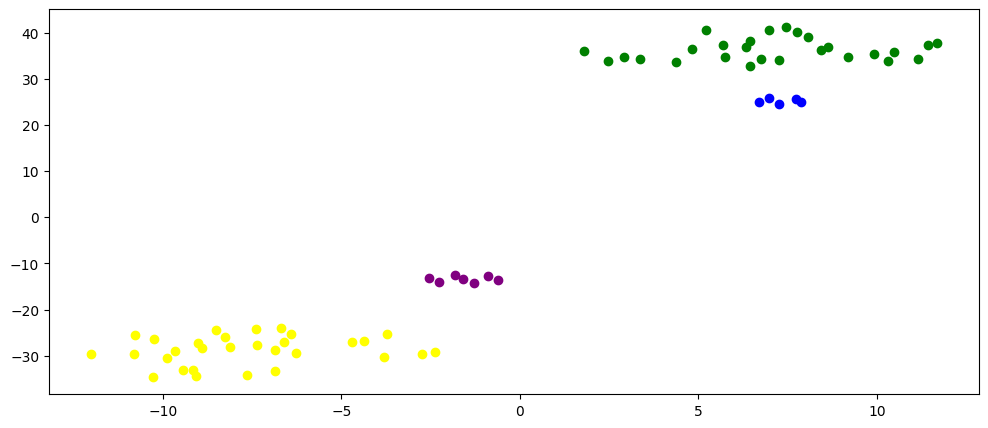

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def tsne_plot():
    "Creates and TSNE model and plots it"
    tokens = []
    labels = []
    color_mapper = {
        -1: 'red',
        0: 'blue',
        1: 'green',
        2: 'yellow',
        3: 'purple',
        4: 'black'
    }

    data = df_track_pool_with_genres.to_dict(orient='records')

    for record in data:
        cluster = record.pop('cluster')
        labels.append(color_mapper[cluster])
        tokens.append(np.array(list(record.values())))
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12,5)) 
    for i in range(len(x)):
        plt.scatter(x[i], y[i], c=labels[i])

    plt.show()


tsne_plot()

#### Nearest Neighbors
Use KNN to find similar tracks for each cluster centroid

In [53]:
centroids = df_track_pool_with_genres.groupby('cluster').mean()
centroids

,gw1,gw2,gw3,gw4,gw5,gw6,aw1,aw2,aw3,aw4,aw5,aw6,track_age,tempo,popularity,valence,energy,loudness,danceability,speechiness,acousticness,instrumentalness,liveness,artist_mean_popularity
cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,5.344446,0.001905,-0.001839,-0.003026,-0.000648,0.000660,-2.377946,0.152807,0.063113,0.029219,0.053630,0.053077,0.019672,0.496855,0.514000,0.163220,0.552400,0.729213,0.742482,0.043419,0.348217,0.911800,0.115480,0.593000
1,-0.611128,0.014054,-0.071821,0.023292,0.031875,-0.164044,-2.286862,0.080864,0.092098,-0.092823,0.073083,0.008287,0.026412,0.498480,0.417407,0.300904,0.701741,0.775087,0.761969,0.061891,0.062055,0.793400,0.125585,0.539506
2,-0.636087,0.044106,-0.081828,0.012715,0.017778,-0.142530,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221,0.024317,0.494078,0.429667,0.219743,0.631433,0.757008,0.701413,0.050257,0.110862,0.762200,0.123393,0.444056
3,5.344446,0.001905,-0.001839,-0.003026,-0.000648,0.000660,3.637336,0.000074,-0.000310,0.000244,0.000100,0.000221,0.016393,0.495790,0.400000,0.189429,0.671571,0.770707,0.734323,0.043328,0.174598,0.705429,0.123057,0.383571


In [54]:
centroid_matrix = centroids.to_numpy()

track_recommendations = []
for eigen_track in centroid_matrix:
    neighbors = nn_model.kneighbors(
        eigen_track.reshape(1, -1), 
        return_distance=False
    )
    for n in neighbors[0]:
        track_recommendations.append(track_db[n]['id'])

recommendations = df_db_tracks[df_db_tracks['id'].isin(track_recommendations)]

In [55]:
recommendations

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,artist_popularity,artist_mean_popularity,artist_max_popularity,track_age
91064,1WuDqYgQZIlg9E9GPmRVt7,Electrik Move,32,104000,0,['DJ Mingo'],[3DQuNOt9FGmbDh8KlaaL39],2018-11-16,0.804,0.601,10,-10.233,0,0.0740,0.000224,0.784,0.1200,0.2480,112.026,4,[],[21],21.0,21.0,4.0
93054,0eZPeiMttWBveKreWHLjhI,sometimes it’s scary…but it’s still you and me...,30,379464,0,['Leaving Laurel'],[2Tz2klWNZNGyvOMr8gT98t],2020-12-17,0.748,0.787,6,-6.613,1,0.0670,0.004190,0.810,0.1590,0.1120,124.012,4,[progressive house],[44],44.0,44.0,2.0
93343,4iVUdetI0cQ4cOmuvGEyuA,Feel Love in the Music (Chill Electronic Music...,25,185805,0,['Greg Sletteland'],[1UiwiBUiZQ4JkuSNnlSOmB],2020-01-01,0.853,0.381,7,-11.549,1,0.0552,0.270000,0.950,0.1080,0.2880,123.994,4,[],[41],41.0,41.0,3.0
103384,4LoBPiqiPBzKqSahyxyAul,Love Theme from St. Elmo's Fire - Instrumental,38,210826,0,['David Foster'],[0SgQK24WzZf2pXBXYqHJYF],1985-01-01,0.569,0.392,8,-14.258,1,0.0347,0.462000,0.793,0.1100,0.2990,125.213,4,[],[54],54.0,54.0,38.0
103703,65Wspymr1UkFIT0WRyVJnI,Love Theme from St. Elmo's Fire - Instrumental,48,209400,0,['David Foster'],[0SgQK24WzZf2pXBXYqHJYF],1986-06-11,0.570,0.404,8,-13.761,1,0.0361,0.501000,0.668,0.1040,0.3120,125.201,4,[],[54],54.0,54.0,36.0
111210,5l3TZLe5uEk7vdXbHghZZW,Rej,44,488920,0,['Âme'],[5muFO8VqYRCRW13EkvX564],2005-01-01,0.784,0.771,1,-7.954,1,0.0500,0.019800,0.902,0.1050,0.3120,125.009,4,"[ tech house, german house, microhouse, mini...",[51],51.0,51.0,18.0
115343,1z8jxUh4zX5ieWFMn3NWG8,The Whistling Man,47,419997,0,"['Blaqnick', 'MasterBlaq', 'Uncle Jo']","[19qLtUQKu1KK3UrQtIoVXF, 2YaMctZMRwW4wYlkvwLK...",2020-10-16,0.499,0.552,10,-10.505,0,0.0502,0.002960,0.887,0.2700,0.0611,112.024,4,[],[43],43.0,43.0,2.0
116100,5tdkYlkNWbjWG0SuZK4L55,Stoko,42,365409,0,"['Soa Mattrix', 'Sir Trill']","[1GH6EGidwzL60gzvHscBHH, 4QkKUb73NVonTlAZaShsuY]",2021-01-18,0.838,0.652,1,-12.167,1,0.0510,0.000615,0.762,0.0933,0.2430,113.016,4,[],[41],41.0,41.0,2.0
201249,1WemXH4wlsgzBc0s6S1S98,No Love Me,39,112131,0,['Paw Dee'],[4xb9Nn6AcjEfqKTMAZTvT6],2021-01-06,0.807,0.700,4,-9.217,0,0.0393,0.000749,0.790,0.1050,0.4020,121.996,4,[],[32],32.0,32.0,2.0
232059,2AVidS1DbHOG9p6Dlr6hIn,Paradise,37,359965,0,['LUTRA'],[0j6beW2nbaPxsK97KRWZVr],2020-06-14,0.739,0.735,11,-8.794,1,0.0452,0.000747,0.764,0.0569,0.1160,123.998,4,[],[28],28.0,28.0,2.0


#### Code example of usage

In [56]:
from recommender_system.algorithm.pre_processing import BasicProcessor

processor = BasicProcessor()

processed_tracks = processor.create_track_vector_from_enhanced_track(tracks=enhanced_tracks)

In [57]:
processed_tracks